In [1]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import plot_model
import os
print(tf.__version__)
#!pip install -q tensorflow-datasets
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

2.9.2


website i used to help me :
-  https://mlhive.com/2021/05/emotion-classification-from-text-using-tensorflow-2

-  https://paperswithcode.com/dataset/goemotions

-  https://thedigitalskye.com/2021/04/19/6-useful-metrics-to-evaluate-binary-classification-models/

-  https://ai.googleblog.com/2021/10/goemotions-dataset-for-fine-grained.html

-  https://keras.io/api/layers/recurrent_layers/bidirectional/

-  https://inside-machinelearning.com/en/efficient-sentences-embedding-visualization-tsne/#Preparing_the_data_-_GoEmotions

In [62]:
vocab_size = 10000  #number of unique words
embedding_dim = 16
max_length = 80
trunc_type='post'
padding_type='post'
oov_tok = ""
training_size = 180000

In [63]:
try:
    from unidecode import unidecode
except ModuleNotFoundError:
    !pip install unidecode
    from unidecode import unidecode

In [64]:
try:
    import datasets
except ModuleNotFoundError:
    !pip install datasets
    import datasets

In [65]:

from datasets import load_dataset


dataset = load_dataset('go_emotions','raw')
emotions = [
 'admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise',
 'neutral']  

  0%|          | 0/1 [00:00<?, ?it/s]

In [66]:
id_label = {str(i):label for i, label in enumerate(emotions)}
label_id = {label:str(i) for i, label in enumerate(emotions)}

id_label

{'0': 'admiration',
 '1': 'amusement',
 '2': 'anger',
 '3': 'annoyance',
 '4': 'approval',
 '5': 'caring',
 '6': 'confusion',
 '7': 'curiosity',
 '8': 'desire',
 '9': 'disappointment',
 '10': 'disapproval',
 '11': 'disgust',
 '12': 'embarrassment',
 '13': 'excitement',
 '14': 'fear',
 '15': 'gratitude',
 '16': 'grief',
 '17': 'joy',
 '18': 'love',
 '19': 'nervousness',
 '20': 'optimism',
 '21': 'pride',
 '22': 'realization',
 '23': 'relief',
 '24': 'remorse',
 '25': 'sadness',
 '26': 'surprise',
 '27': 'neutral'}

In [67]:
df_train=pd.DataFrame.from_dict(dataset["train"])

In [68]:
df_train.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1


In [69]:
df_train.drop(['id','author','subreddit','link_id','parent_id','created_utc','rater_id', 'example_very_unclear'], inplace=True, axis=1)

In [70]:
df_train['text']= df_train['text'].map(lambda x: unidecode(x))

We assign the following variables to split the dataset and manage the cleaning and the tokenisation more easily :
text : the column "text" of df that refers to all the subreddit sentences in the dataframe
feeling :  refere to the different feeling of the text that are in the dataframe from index 1 to the last , 0 correspond to false feeling and 1 to true feeling as we can expect there are 28 sentiments in the dataframe ( from 1 to 27 raws )

In [71]:
text = df_train['text']
# df of all the 28 emotions
feeling = df_train.iloc[:, 1:]

Here we split our dataset , we have here a training sample of 180.000 elements and a testing for the rest of the dataframe so around 35.000 elements

In [72]:
train_text = text[0:training_size]
test_text = text[training_size:]
train_feeling = feeling[0:training_size]
test_feeling = feeling[training_size:]

make all the sentences of equal size, add zeros at the end of the sentencses to fill max tweet lenght

In [73]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_text)

word_index = tokenizer.word_index


train_text = tokenizer.texts_to_sequences(train_text)
train_pad = pad_sequences(train_text, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_text = tokenizer.texts_to_sequences(test_text)
test_pad = pad_sequences(test_text, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [74]:
train_pad = np.array(train_pad)
train_feeling = np.array(train_feeling)
test_pad = np.array(test_pad)
test_feeling = np.array(test_feeling)

MODEL 1 loss = binary cross entropy because we have here feeling with bool argument ( 0 and 1 )

We have here set at the top of the notebook some general parameters for all the models we are going to train, we set a vocabulary size of 100.000 different words and a max-lenght to 150 where the max tweet length is 703

In [75]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dense(28 , activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 80, 16)            160000    
                                                                 
 global_average_pooling1d_3   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 128)               2176      
                                                                 
 dense_7 (Dense)             (None, 28)                3612      
                                                                 
Total params: 165,788
Trainable params: 165,788
Non-trainable params: 0
_________________________________________________________________


In [76]:
num_epochs = 20
history = model.fit(train_pad, train_feeling, epochs=num_epochs, validation_data=(test_pad, test_feeling), verbose=2)

Epoch 1/20
5625/5625 - 18s - loss: 0.1618 - accuracy: 0.2596 - val_loss: 0.1505 - val_accuracy: 0.2875 - 18s/epoch - 3ms/step
Epoch 2/20
5625/5625 - 17s - loss: 0.1447 - accuracy: 0.3092 - val_loss: 0.1394 - val_accuracy: 0.3315 - 17s/epoch - 3ms/step
Epoch 3/20
5625/5625 - 18s - loss: 0.1348 - accuracy: 0.3533 - val_loss: 0.1317 - val_accuracy: 0.3613 - 18s/epoch - 3ms/step
Epoch 4/20
5625/5625 - 18s - loss: 0.1279 - accuracy: 0.3753 - val_loss: 0.1280 - val_accuracy: 0.3724 - 18s/epoch - 3ms/step
Epoch 5/20
5625/5625 - 18s - loss: 0.1239 - accuracy: 0.3875 - val_loss: 0.1259 - val_accuracy: 0.3841 - 18s/epoch - 3ms/step
Epoch 6/20
5625/5625 - 18s - loss: 0.1213 - accuracy: 0.3968 - val_loss: 0.1250 - val_accuracy: 0.3839 - 18s/epoch - 3ms/step
Epoch 7/20
5625/5625 - 18s - loss: 0.1191 - accuracy: 0.4046 - val_loss: 0.1239 - val_accuracy: 0.3930 - 18s/epoch - 3ms/step
Epoch 8/20
5625/5625 - 18s - loss: 0.1173 - accuracy: 0.4106 - val_loss: 0.1234 - val_accuracy: 0.3924 - 18s/epoch - 3

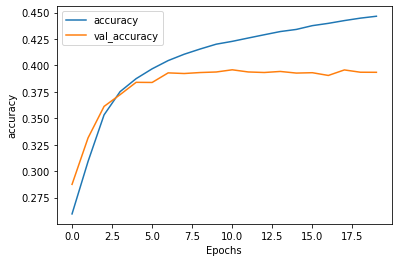

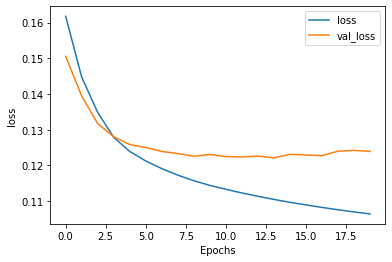

In [77]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

we can see here that there is no overfitting because when loss decrease the accuracy increase. But we have also only 44% accuracy so we will try some other models.

but first Lets try this model with a loss of categorical_crossentropy instead of binary_crossentropy to see if it can increase our model performance and put vocab_size = 10000 to reduce the time taken to train and test our model

In [78]:
vocab_size = 10000 
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dense(28 , activation='sigmoid')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 80, 16)            160000    
                                                                 
 global_average_pooling1d_4   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_8 (Dense)             (None, 128)               2176      
                                                                 
 dense_9 (Dense)             (None, 28)                3612      
                                                                 
Total params: 165,788
Trainable params: 165,788
Non-trainable params: 0
_________________________________________________________________


In [79]:
num_epochs = 20
history = model.fit(train_pad, train_feeling, epochs=num_epochs, validation_data=(test_pad, test_feeling), verbose=2)

Epoch 1/20
5625/5625 - 20s - loss: 23.8423 - accuracy: 0.1362 - val_loss: 61.1330 - val_accuracy: 0.0968 - 20s/epoch - 4ms/step
Epoch 2/20
5625/5625 - 21s - loss: 132.3587 - accuracy: 0.0948 - val_loss: 231.4224 - val_accuracy: 0.2635 - 21s/epoch - 4ms/step
Epoch 3/20
5625/5625 - 20s - loss: 298.5028 - accuracy: 0.0943 - val_loss: 421.1852 - val_accuracy: 0.0254 - 20s/epoch - 4ms/step
Epoch 4/20
5625/5625 - 25s - loss: 529.9109 - accuracy: 0.0945 - val_loss: 760.6068 - val_accuracy: 0.0373 - 25s/epoch - 4ms/step
Epoch 5/20
5625/5625 - 21s - loss: 820.9075 - accuracy: 0.0948 - val_loss: 856.2493 - val_accuracy: 0.0131 - 21s/epoch - 4ms/step
Epoch 6/20
5625/5625 - 25s - loss: 1197.2296 - accuracy: 0.0941 - val_loss: 1139.9958 - val_accuracy: 0.0175 - 25s/epoch - 4ms/step
Epoch 7/20
5625/5625 - 22s - loss: 1571.9310 - accuracy: 0.0953 - val_loss: 1893.2926 - val_accuracy: 0.0240 - 22s/epoch - 4ms/step
Epoch 8/20
5625/5625 - 22s - loss: 2066.5349 - accuracy: 0.0961 - val_loss: 1746.0232 - 

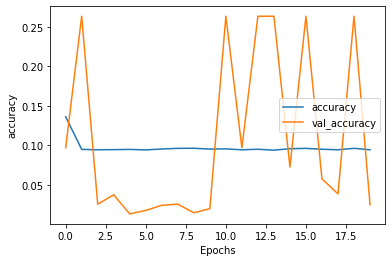

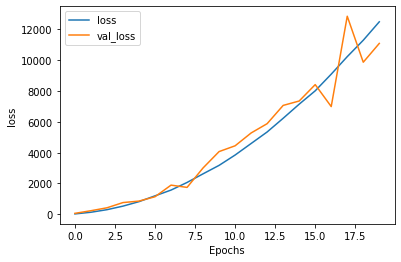

In [80]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

We can see here that the categorical crossentropy doesn't help at all because we have a loss function increasing over the epochs and the accuracy stagning. This is not what we are looking for. Lets try the first model with binary crossentropy and some dropout to see if we can win some% of accuracy as we saw in class. Lets start with a dropout at 0.2 and then 0.5.

In [81]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dense(28 , activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 80, 16)            160000    
                                                                 
 global_average_pooling1d_5   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_10 (Dense)            (None, 128)               2176      
                                                                 
 dense_11 (Dense)            (None, 28)                3612      
                                                                 
Total params: 165,788
Trainable params: 165,788
Non-trainable params: 0
________________________________________________

In [82]:
num_epochs = 20
history = model.fit(train_pad, train_feeling, epochs=num_epochs, validation_data=(test_pad, test_feeling), verbose=2)

Epoch 1/20
5625/5625 - 31s - loss: 0.1581 - accuracy: 0.2726 - val_loss: 0.1453 - val_accuracy: 0.2985 - 31s/epoch - 6ms/step
Epoch 2/20
5625/5625 - 26s - loss: 0.1401 - accuracy: 0.3290 - val_loss: 0.1343 - val_accuracy: 0.3580 - 26s/epoch - 5ms/step
Epoch 3/20
5625/5625 - 25s - loss: 0.1316 - accuracy: 0.3652 - val_loss: 0.1291 - val_accuracy: 0.3718 - 25s/epoch - 4ms/step
Epoch 4/20
5625/5625 - 21s - loss: 0.1269 - accuracy: 0.3778 - val_loss: 0.1263 - val_accuracy: 0.3769 - 21s/epoch - 4ms/step
Epoch 5/20
5625/5625 - 20s - loss: 0.1238 - accuracy: 0.3887 - val_loss: 0.1243 - val_accuracy: 0.3879 - 20s/epoch - 4ms/step
Epoch 6/20
5625/5625 - 21s - loss: 0.1216 - accuracy: 0.3969 - val_loss: 0.1235 - val_accuracy: 0.3899 - 21s/epoch - 4ms/step
Epoch 7/20
5625/5625 - 20s - loss: 0.1200 - accuracy: 0.4024 - val_loss: 0.1227 - val_accuracy: 0.3951 - 20s/epoch - 4ms/step
Epoch 8/20
5625/5625 - 19s - loss: 0.1188 - accuracy: 0.4064 - val_loss: 0.1231 - val_accuracy: 0.3963 - 19s/epoch - 3

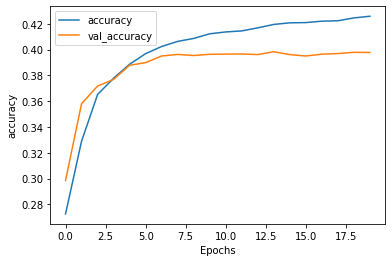

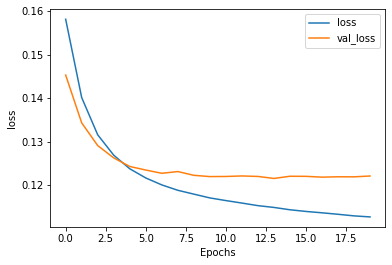

In [83]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Now let's try with a dropou at 0.5

In [84]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dense(28 , activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 80, 16)            160000    
                                                                 
 global_average_pooling1d_6   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_12 (Dense)            (None, 128)               2176      
                                                                 
 dense_13 (Dense)            (None, 28)                3612      
                                                                 
Total params: 165,788
Trainable params: 165,788
Non-trainable params: 0
________________________________________________

In [85]:
num_epochs = 20
history = model.fit(train_pad, train_feeling, epochs=num_epochs, validation_data=(test_pad, test_feeling), verbose=2)

Epoch 1/20
5625/5625 - 26s - loss: 0.1595 - accuracy: 0.2687 - val_loss: 0.1473 - val_accuracy: 0.3050 - 26s/epoch - 5ms/step
Epoch 2/20
5625/5625 - 28s - loss: 0.1433 - accuracy: 0.3165 - val_loss: 0.1373 - val_accuracy: 0.3430 - 28s/epoch - 5ms/step
Epoch 3/20
5625/5625 - 26s - loss: 0.1364 - accuracy: 0.3469 - val_loss: 0.1317 - val_accuracy: 0.3618 - 26s/epoch - 5ms/step
Epoch 4/20
5625/5625 - 19s - loss: 0.1330 - accuracy: 0.3574 - val_loss: 0.1290 - val_accuracy: 0.3700 - 19s/epoch - 3ms/step
Epoch 5/20
5625/5625 - 18s - loss: 0.1308 - accuracy: 0.3635 - val_loss: 0.1278 - val_accuracy: 0.3734 - 18s/epoch - 3ms/step
Epoch 6/20
5625/5625 - 18s - loss: 0.1294 - accuracy: 0.3685 - val_loss: 0.1263 - val_accuracy: 0.3792 - 18s/epoch - 3ms/step
Epoch 7/20
5625/5625 - 18s - loss: 0.1283 - accuracy: 0.3722 - val_loss: 0.1254 - val_accuracy: 0.3854 - 18s/epoch - 3ms/step
Epoch 8/20
5625/5625 - 18s - loss: 0.1274 - accuracy: 0.3751 - val_loss: 0.1254 - val_accuracy: 0.3884 - 18s/epoch - 3

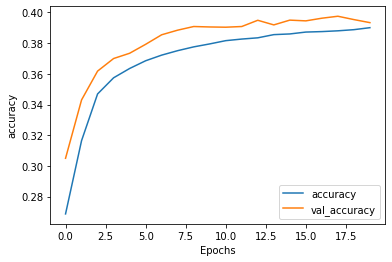

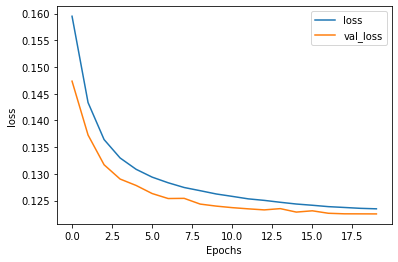

In [86]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

We can see here that the accuracy is still a little bit higher than 0.40% but not much and not improving even with regularization function as dropout.
We need to choose an other metric than accuracy. 

In [87]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dense(28 , activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[tf.keras.metrics.AUC()])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 80, 16)            160000    
                                                                 
 global_average_pooling1d_7   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_14 (Dense)            (None, 128)               2176      
                                                                 
 dense_15 (Dense)            (None, 28)                3612      
                                                                 
Total params: 165,788
Trainable params: 165,788
Non-trainable params: 0
_________________________________________________________________


In [88]:
num_epochs = 20
history = model.fit(train_pad, train_feeling, epochs=num_epochs, validation_data=(test_pad, test_feeling), verbose=2)

Epoch 1/20
5625/5625 - 25s - loss: 0.1612 - auc: 0.7356 - val_loss: 0.1496 - val_auc: 0.7727 - 25s/epoch - 4ms/step
Epoch 2/20
5625/5625 - 26s - loss: 0.1451 - auc: 0.7978 - val_loss: 0.1409 - val_auc: 0.8141 - 26s/epoch - 5ms/step
Epoch 3/20
5625/5625 - 22s - loss: 0.1359 - auc: 0.8353 - val_loss: 0.1328 - val_auc: 0.8464 - 22s/epoch - 4ms/step
Epoch 4/20
5625/5625 - 26s - loss: 0.1287 - auc: 0.8611 - val_loss: 0.1285 - val_auc: 0.8620 - 26s/epoch - 5ms/step
Epoch 5/20
5625/5625 - 25s - loss: 0.1244 - auc: 0.8754 - val_loss: 0.1260 - val_auc: 0.8701 - 25s/epoch - 4ms/step
Epoch 6/20
5625/5625 - 19s - loss: 0.1215 - auc: 0.8842 - val_loss: 0.1250 - val_auc: 0.8732 - 19s/epoch - 3ms/step
Epoch 7/20
5625/5625 - 18s - loss: 0.1191 - auc: 0.8910 - val_loss: 0.1236 - val_auc: 0.8772 - 18s/epoch - 3ms/step
Epoch 8/20
5625/5625 - 20s - loss: 0.1171 - auc: 0.8963 - val_loss: 0.1231 - val_auc: 0.8786 - 20s/epoch - 4ms/step
Epoch 9/20
5625/5625 - 19s - loss: 0.1155 - auc: 0.9005 - val_loss: 0.12

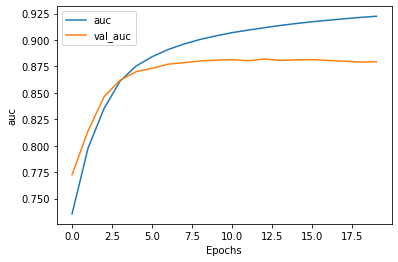

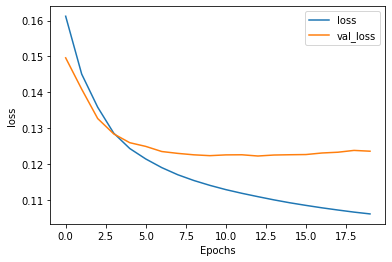

In [91]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "auc")
plot_graphs(history, "loss")

We can see here a better accuracy , but we can also see that the model is overfitting very much. Lets add a regularization as for the accuracy metric with a dropout function

In [92]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dense(28 , activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[tf.keras.metrics.AUC()])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 80, 16)            160000    
                                                                 
 global_average_pooling1d_8   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_16 (Dense)            (None, 128)               2176      
                                                                 
 dense_17 (Dense)            (None, 28)                3612      
                                                                 
Total params: 165,788
Trainable params: 165,788
Non-trainable params: 0
________________________________________________

In [93]:
num_epochs = 20
history = model.fit(train_pad, train_feeling, epochs=num_epochs, validation_data=(test_pad, test_feeling), verbose=2)

Epoch 1/20
5625/5625 - 23s - loss: 0.1594 - auc_1: 0.7405 - val_loss: 0.1470 - val_auc_1: 0.7899 - 23s/epoch - 4ms/step
Epoch 2/20
5625/5625 - 19s - loss: 0.1431 - auc_1: 0.8082 - val_loss: 0.1363 - val_auc_1: 0.8332 - 19s/epoch - 3ms/step
Epoch 3/20
5625/5625 - 20s - loss: 0.1360 - auc_1: 0.8369 - val_loss: 0.1313 - val_auc_1: 0.8523 - 20s/epoch - 4ms/step
Epoch 4/20
5625/5625 - 20s - loss: 0.1326 - auc_1: 0.8502 - val_loss: 0.1291 - val_auc_1: 0.8616 - 20s/epoch - 4ms/step
Epoch 5/20
5625/5625 - 21s - loss: 0.1306 - auc_1: 0.8570 - val_loss: 0.1277 - val_auc_1: 0.8648 - 21s/epoch - 4ms/step
Epoch 6/20
5625/5625 - 19s - loss: 0.1294 - auc_1: 0.8614 - val_loss: 0.1262 - val_auc_1: 0.8702 - 19s/epoch - 3ms/step
Epoch 7/20
5625/5625 - 19s - loss: 0.1285 - auc_1: 0.8642 - val_loss: 0.1258 - val_auc_1: 0.8713 - 19s/epoch - 3ms/step
Epoch 8/20
5625/5625 - 23s - loss: 0.1278 - auc_1: 0.8665 - val_loss: 0.1251 - val_auc_1: 0.8730 - 23s/epoch - 4ms/step
Epoch 9/20
5625/5625 - 19s - loss: 0.127

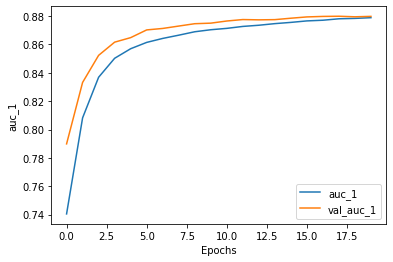

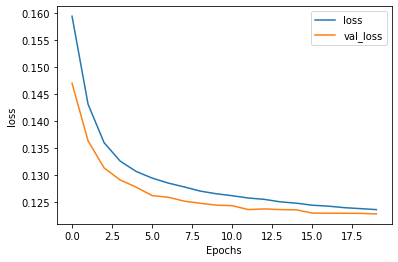

In [95]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "auc_1")
plot_graphs(history, "loss")

We have here some good result. lets now see with other model than GlobalAveragePooling like bidirectional and with some callback layer as we saw during the class

In [96]:
from keras.layers import LSTM
from keras.layers import Bidirectional

In [97]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(LSTM(8, return_sequences=True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(28 , activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[tf.keras.metrics.AUC()])


In [99]:
from keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 90
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr
callbacks = [
    keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
]
callbacks = keras.callbacks.ModelCheckpoint("model_sparse.h5", save_best_only=True)

In [100]:
num_epochs = 20
history = model.fit(train_pad, train_feeling, epochs=num_epochs, callbacks = callbacks , validation_data=(test_pad, test_feeling), verbose=2)

Epoch 1/20
5625/5625 - 170s - loss: 0.1559 - auc_2: 0.7659 - val_loss: 0.1427 - val_auc_2: 0.8058 - 170s/epoch - 30ms/step
Epoch 2/20
5625/5625 - 162s - loss: 0.1379 - auc_2: 0.8274 - val_loss: 0.1347 - val_auc_2: 0.8395 - 162s/epoch - 29ms/step
Epoch 3/20
5625/5625 - 158s - loss: 0.1314 - auc_2: 0.8520 - val_loss: 0.1308 - val_auc_2: 0.8528 - 158s/epoch - 28ms/step
Epoch 4/20
5625/5625 - 159s - loss: 0.1274 - auc_2: 0.8647 - val_loss: 0.1287 - val_auc_2: 0.8602 - 159s/epoch - 28ms/step
Epoch 5/20
5625/5625 - 174s - loss: 0.1246 - auc_2: 0.8735 - val_loss: 0.1272 - val_auc_2: 0.8647 - 174s/epoch - 31ms/step
Epoch 6/20
5625/5625 - 157s - loss: 0.1224 - auc_2: 0.8797 - val_loss: 0.1268 - val_auc_2: 0.8665 - 157s/epoch - 28ms/step
Epoch 7/20
5625/5625 - 159s - loss: 0.1206 - auc_2: 0.8846 - val_loss: 0.1260 - val_auc_2: 0.8690 - 159s/epoch - 28ms/step
Epoch 8/20
5625/5625 - 159s - loss: 0.1190 - auc_2: 0.8892 - val_loss: 0.1256 - val_auc_2: 0.8703 - 159s/epoch - 28ms/step
Epoch 9/20
5625/

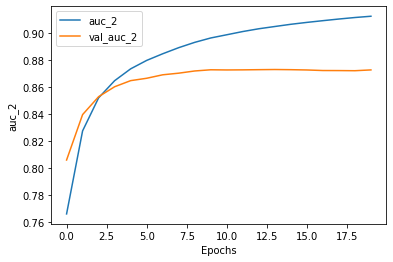

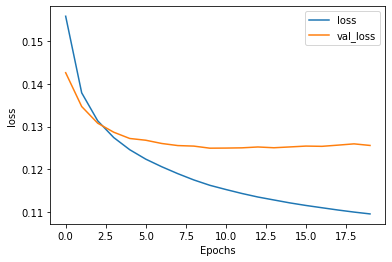

In [101]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "auc_2")
plot_graphs(history, "loss")

We can see some overfitting with 20 epochs here , so lets try to put some dropout to delete it


In [102]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(LSTM(8, return_sequences=True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(28 , activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[tf.keras.metrics.AUC()])


In [103]:
num_epochs = 20
history = model.fit(train_pad, train_feeling, epochs=num_epochs, callbacks = callbacks , validation_data=(test_pad, test_feeling), verbose=2)

Epoch 1/20
5625/5625 - 176s - loss: 0.1602 - auc_3: 0.7484 - val_loss: 0.1442 - val_auc_3: 0.8021 - 176s/epoch - 31ms/step
Epoch 2/20
5625/5625 - 163s - loss: 0.1435 - auc_3: 0.8086 - val_loss: 0.1401 - val_auc_3: 0.8210 - 163s/epoch - 29ms/step
Epoch 3/20
5625/5625 - 161s - loss: 0.1397 - auc_3: 0.8254 - val_loss: 0.1372 - val_auc_3: 0.8322 - 161s/epoch - 29ms/step
Epoch 4/20
5625/5625 - 159s - loss: 0.1372 - auc_3: 0.8350 - val_loss: 0.1353 - val_auc_3: 0.8389 - 159s/epoch - 28ms/step
Epoch 5/20
5625/5625 - 158s - loss: 0.1350 - auc_3: 0.8421 - val_loss: 0.1333 - val_auc_3: 0.8448 - 158s/epoch - 28ms/step
Epoch 6/20
5625/5625 - 157s - loss: 0.1329 - auc_3: 0.8486 - val_loss: 0.1315 - val_auc_3: 0.8511 - 157s/epoch - 28ms/step
Epoch 7/20
5625/5625 - 158s - loss: 0.1314 - auc_3: 0.8543 - val_loss: 0.1308 - val_auc_3: 0.8538 - 158s/epoch - 28ms/step
Epoch 8/20
5625/5625 - 163s - loss: 0.1301 - auc_3: 0.8586 - val_loss: 0.1300 - val_auc_3: 0.8569 - 163s/epoch - 29ms/step
Epoch 9/20
5625/

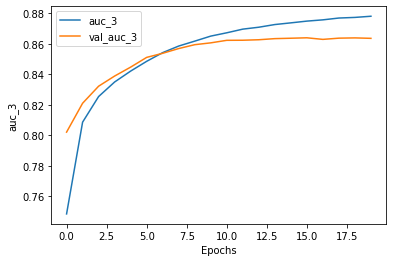

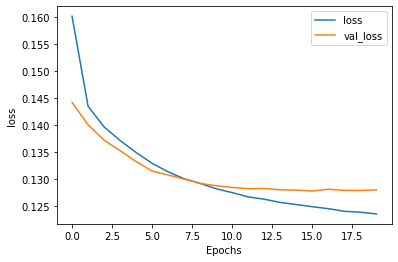

In [104]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "auc_3")
plot_graphs(history, "loss")

here with the dropout , we have a less overfitting function and have around 88% accuracy wich is pretty correct for this model and the guess of feeling for text as there is multiple feelings for certains text as said in the documentation of the dataset